### fft.freq do fft2d

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import MigPreFuncoes
import SlantStack
import scipy

In [63]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=110
nz=100;
dt=.005
ntr=nx
dx=10  #meters
dz=dx  #meters
c=1992 #velocidade
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
#print(nt)
nd2=nt+1; 
W=np.zeros(2*nt);
#print(W.shape)
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

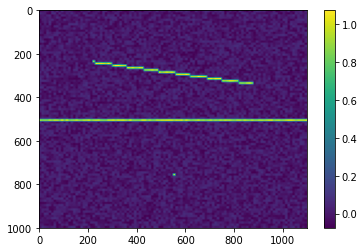

In [64]:
[X,Z]=np.meshgrid(x,z)
zz=(dz*Z)**2
X=(dx*X)                                          
R=X*0.0;

#Refletor Horizontal    
for i in range(int(0),int(nx)):
    R[int(np.round(nz/2)),i]=1
    
#Refletor Dip
x_ini = int(np.round(1*nx/5))
x_fim = int(np.round(4*nx/5))
theta=30

for i in range(x_ini,x_fim):
    z = int(np.round(i*np.cos(theta)) + np.round(nz/5))
    R[z,i]=1

#Ponto Difrator
R[int(np.round(6*nz/8)),int(np.round(nx/2))]=1

nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.15

plt.imshow(R, extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.colorbar()
plt.show()

In [65]:
#Vagarosidade

SW=np.ones([nz,nx])*1/c

In [66]:
#Tabela do Tempo de Transito

with open('../Data/CSG_diffbar/Tabti/raiosTabti.npy', 'rb') as f:
    TTh = np.load(f)

timer=np.round(TTh/dt)+1

print(f"TTh.shape={TTh.shape}")

TTh.shape=(110, 100, 110)


In [67]:
#Creating the synthetic csg

dsx = 1
nsx = nx
ngx = nx
path = "Data/CSG_diffbar/Tabti/dipangle_example"

#files = MigPreFuncoes.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,path)

In [68]:
files = []

for i in range(nx):
    filename = '../Data/CSG_diffbar/Tabti/dipangle_example_{}'.format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [69]:
#Slant Stack

pmin = -1
pmax = 1
dp = 0.1
xwin=zwin=30
dx=dz=1
x_ini=z_ini=0

#pm,sm = SlantStack.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp)

#with open("Data/CSG_diffbar/Tabti/dipangle_dip", "wb") as f:
#    np.save(f,pm)
#    
#with open("Data/CSG_diffbar/Tabti/dipangle_semblance", "wb") as f: 
#    np.save(f,sm)

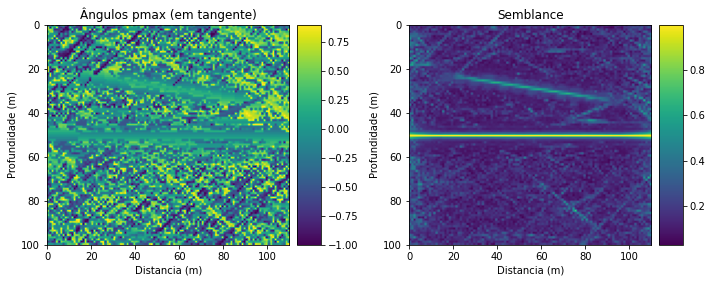

In [70]:
with open("../Data/CSG_diffbar/Tabti/dipangle_dip", "rb") as f:
    pm = np.load(f)
    
with open("../Data/CSG_diffbar/Tabti/dipangle_semblance", "rb") as f: 
    sm = np.load(f)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Ângulos pmax (em tangente)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(pm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Semblance")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(sm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [71]:

m_theta = np.arctan(pm)
X = np.sin(m_theta)
Y = np.cos(m_theta)

In [72]:
isx = int(nx/2)
gather1h = files[isx]

In [73]:
#Funções que vou usar para  slope filter:

def tabti_taper(nx,nz,app):
    ar = np.zeros([nz,nx])
    center = int(nx/2)
    window = np.hanning(2*app)

    if center-app<0:
        if center+app>nx:
            lw_2 = int(len(window)/2)            
            ar[:,:] = window[(lw_2 - center):(lw_2 + center)]
        else:
            ar[:,0:(center+app)] = window[abs(center-app):]   
    elif (center+app)>nx:
        ar[:,(abs(center-app)):] = window[0:(nx - abs(center-app))]
    else:
        ar[:,(center-app):(center+app)] = window
        
    #plt.plot(ar)
    #plt.show()
        
    return ar

#####################

def slope_filter(gather,nx,nz):
    fk = scipy.fft.fft2(gather)
    fk = scipy.fft.fftshift(fk,axes=1)
    tap = tabti_taper(nx,nz,2)
    fk_tapered = fk*tap
    new_tapered = scipy.fft.ifft2(fk_tapered)
    return new_tapered

In [74]:
isx=int(nx/2)

amplitudes = []
ws = []
tabtis = []
mig=np.zeros([nz,nx])
mig_diff=np.zeros([nz,nx])
tabti=np.zeros([nz,ntr])

profile=int(nx/2)

for igx in range(0,ntr):
        w = MigPreFuncoes.peso(TTh,dt,X,Y,igx,isx)
        ws.append(w)
        
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
        t2 = (t<nt)*t
        
        trace1=gather1h.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
        trace1 = trace1.reshape([nz,nx])
        trace2 = trace1*w**4
        trace3 = trace1*(1-w**4)
        
        amplitudes.append(trace1)
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
        mig_diff[0:nz,0:nx]=mig_diff[0:nz,0:nx] + trace3
        
        tabti[0:nz,igx]=trace1[0:nz,profile]
        tabtis.append(tabti)
        
amplitudes = np.array(amplitudes)
ws = np.array(ws)
tabtis = np.array(tabtis)

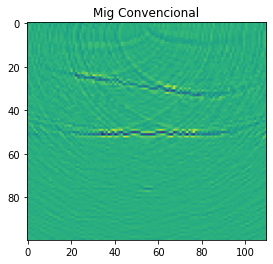

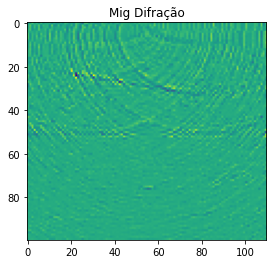

In [75]:
plt.imshow(mig)
plt.title("Mig Convencional")
plt.show()

plt.imshow(mig_diff)
plt.title("Mig Difração")
plt.show()

### Na próxima célula mostro o passo a passo de como filtrar o painel Tabti 

- Transformada de Fourier 2D
- Shift
- Taper
- Transformada Inversa
- Multiplica pela função peso $w$

In [76]:
dcol = (FreqCompCols[1] - FreqCompCols[0])
drow = (FreqCompRows[1] - FreqCompRows[0])

init_col = FreqCompCols[0]
fim_col = FreqCompCols[-1]
init_row = FreqCompRows[0]
fim_row = FreqCompRows[-1]

print(len(FreqCompCols))
print(len(FreqCompRows))

NameError: name 'FreqCompCols' is not defined

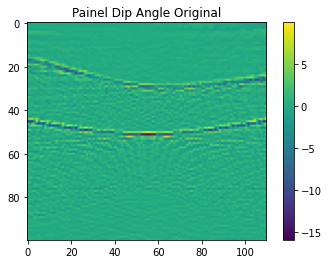

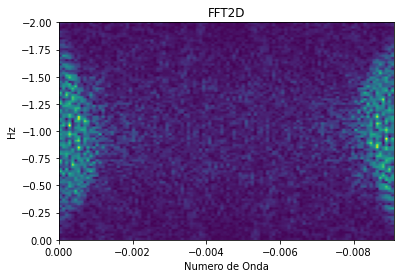

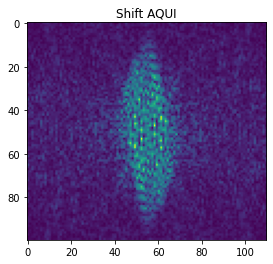

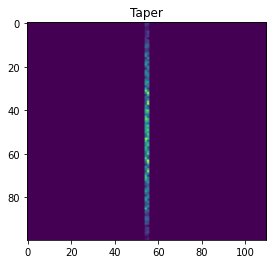

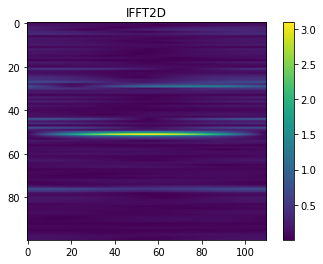

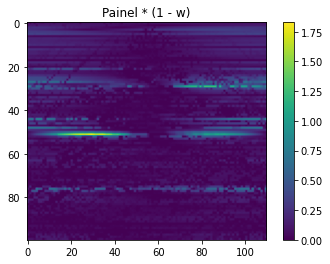

In [77]:
dip_angle = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    dip_angle.append(da)
    
dip_angle = np.array(dip_angle)
dip_angle_55 = dip_angle[55,:,:]

plt.imshow(dip_angle_55)
plt.title("Painel Dip Angle Original")
plt.colorbar()
plt.show()

fk = scipy.fft.fft2(dip_angle_55)


###### TENTANDO FAZER O FFTFREQ 2D
FreqCompRows = np.fft.fftfreq(fk.shape[0],d=dt) #tempo 
FreqCompCols = np.fft.fftfreq(fk.shape[1],d=dx) #espaço

dcol = (FreqCompCols[1] - FreqCompCols[0])
drow = (FreqCompRows[1] - FreqCompRows[0])

init_col = FreqCompCols[0]
fim_col = FreqCompCols[-1]
init_row = FreqCompRows[0]
fim_row = FreqCompRows[-1]
###### FALHANDO COMO SEMPRE


plt.imshow(np.abs(fk),extent=[init_col,fim_col,init_row,fim_row],aspect="auto") #VERIFICAR!
plt.title("FFT2D")
plt.xlabel("Numero de Onda")
plt.ylabel("Hz")
plt.show()

fk = scipy.fft.fftshift(fk,axes=1)

plt.imshow(np.abs(fk))
plt.title("Shift AQUI")
plt.show()

tap = tabti_taper(nx,nz,2)
fk_tapered = fk*tap

plt.imshow(np.abs(fk_tapered))
plt.title("Taper")
plt.show()

new_tapered = scipy.fft.ifft2(fk_tapered)

plt.imshow(np.abs(new_tapered))
plt.title("IFFT2D")
plt.colorbar()
plt.show()

dip_final = new_tapered*(1-ws[55]**8)

plt.imshow(np.abs(dip_final))
plt.title("Painel * (1 - w)")
plt.colorbar()
plt.show()

### Agora, faço esse processo para cada painel Tabti do nosso cubo de dados

No fim, a soma dos painéis deve ser semelhante à migração.

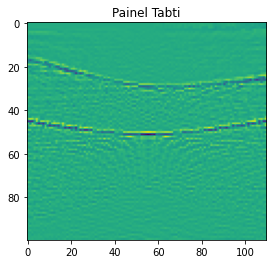

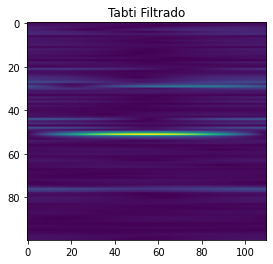

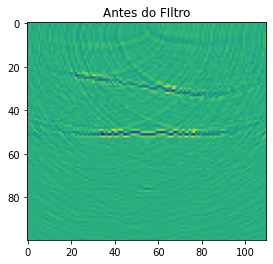

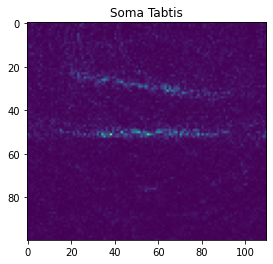

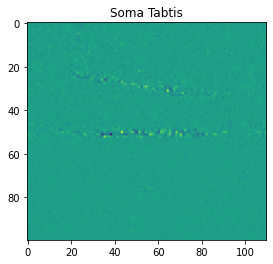

In [78]:
plt.imshow(amplitudes[:,:,isx].T)
plt.title("Painel Tabti")
plt.show()

taps = []
taps_before = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    new_tapered = slope_filter(da,nx,nz) #dip filter
    new_tapered = new_tapered#*(1-ws[i])**2 #multiplicando pelo peso w
    taps.append(new_tapered)
    taps_before.append(da)

taps = np.array(taps)
taps_before = np.array(taps_before)

plt.imshow(np.abs(taps[isx,:,:]))
plt.title("Tabti Filtrado")
plt.show()

summed = np.sum(taps,axis=2)

summed_before = np.sum(taps_before,axis=2)

plt.imshow(summed_before.T)
plt.title("Antes do FIltro")
plt.show()

plt.imshow(np.abs(summed).T)
plt.title("Soma Tabtis")
plt.show()

plt.imshow(np.real(summed).T)
plt.title("Soma Tabtis")
plt.show()

In [ ]:
plt.imshow(amplitudes[:,:,isx].T)
plt.title("Painel Tabti")
plt.show()

taps = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    new_tapered = slope_filter(da,nx,nz) #dip filter
    new_tapered = new_tapered*(1-ws[i]**8) #multiplicando pelo peso diff w
    taps.append(new_tapered)

taps = np.array(taps)

plt.imshow(taps[isx,:,:].real)
plt.title("Tabti Filtrado")
plt.show()

summed = np.sum(taps,axis=2)

plt.imshow((summed.T).real)
plt.title("Soma Tabtis")
plt.show()

In [80]:
dx=1.0 #(m) Discretização em X
dz=1.0 #(m) Discretização em Y
nz=120 #Tamanho do Grid em Z
ntr=nx=240 #Tamanho do Grid em X
c=250 #m/s

In [81]:
with open('../Data/time_table_barra.npy', 'rb') as f:
    TTh = np.load(f)


dt=0.004


timer=np.round(TTh/dt)+1

In [82]:
shot = 120
filename = '../Data/CSG_diffbar/barra_gather_shotCenter{}'.format(int(shot))
with open(filename, 'rb') as file:
    gather1 = np.load(file)

In [83]:
mig=np.zeros([nz,nx])
tabti=np.zeros([nz,ntr])
amplitudes=[]
profile=int(np.round(2.5*nx/5))
isx=120

z = int(np.round(nz*2/3))
tempo_d=np.zeros([nz,ntr])
for igx in range(0,ntr):
        #w = MigPreFuncoes.peso(TTh,dt,X,Y,igx,isx)
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
        t2 = (t<nt)*t
        trace1=gather1.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
        trace1 = trace1.reshape([nz,nx])
        amplitudes.append(trace1)
        #trace2 = trace1*w
        #trace3 = trace1*(1-w)
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
        tabti[0:nz,igx]=trace1[0:nz,profile]
        #tabti2[0:nz,igx]=trace2[0:nz,profile]
        #tabti3[0:nz,igx]=trace3[0:nz,profile]
        tempo_d[0:nz,igx]=t2[0:nz,profile]
        
amplitudes = np.array(amplitudes)

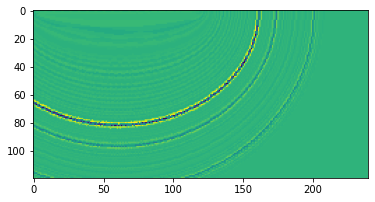

In [84]:
plt.imshow(amplitudes[0])

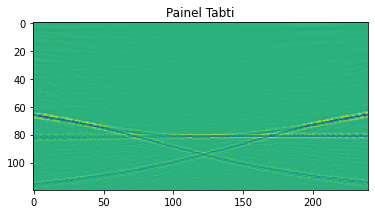

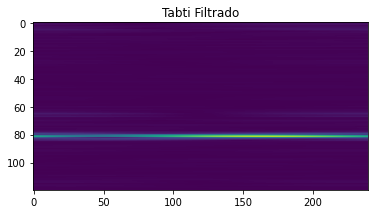

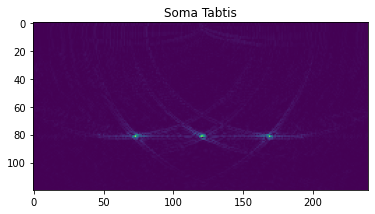

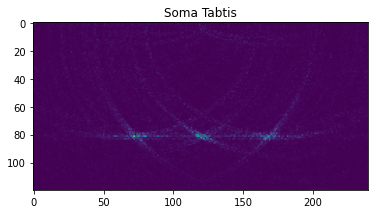

In [85]:
plt.imshow(amplitudes[:,:,120].T)
plt.title("Painel Tabti")
plt.show()

taps_before = []
taps = []

for i in range(ntr):
    da = amplitudes[:,:,i].T
    taps_before.append(da)
    new_tapered = slope_filter(da,nx,nz)
    taps.append(new_tapered)

taps = np.array(taps)
taps_before = np.array(taps_before)

plt.imshow(np.abs(taps[120,:,:]))
plt.title("Tabti Filtrado")
plt.show()

summed_bf = np.sum(taps_before,axis=2)

plt.imshow(np.abs(summed_bf).T)
plt.title("Soma Tabtis")
plt.show()

summed = np.sum(taps,axis=2)

plt.imshow(np.abs(summed).T)
plt.title("Soma Tabtis")
plt.show()

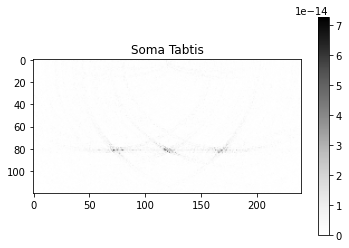

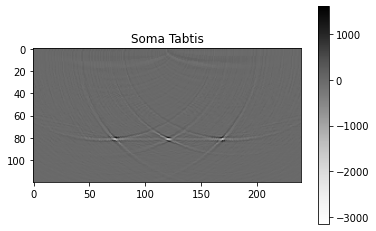

In [89]:
plt.imshow(np.abs(summed).T,cmap="Greys")
plt.colorbar()
plt.title("Soma Tabtis")
plt.show()

plt.imshow(np.real(summed_bf).T,cmap="Greys")
plt.colorbar()
plt.title("Soma Tabtis")
plt.show()